In [1]:
from torch import normal
from torch import tensor
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
from IPython.display import display

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    transforms.Resize((128, 128))])

celebs=datasets.CelebA(root='./celeb/', 
                       transform=transform,
                       download=True)

Files already downloaded and verified


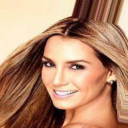

In [3]:
import torchvision as tv
display_trans=tv.transforms.ToPILImage()

# Returns PIL Image from tensor data with pixel RGB values ranging from -1 to 1
def tensorToImage(t, func=lambda x : (x+1)/2):
    display_trans=tv.transforms.ToPILImage()
    return display_trans(func(t))

tensorToImage(celebs[0][0])

In [4]:
# tensor of feature attributes
celebs[0][1]

tensor([0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0,
        1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1])

In [5]:
import torch
im=celebs[0][0]
im.shape

torch.Size([3, 128, 128])

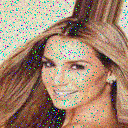

In [6]:
from math import sqrt
# example run of adding gaussian noise to image
var=0.02
im=normal(mean=sqrt(1-sqrt(0.1))*im, std=sqrt(var))

tensorToImage(im)

In [7]:
from math import sqrt
# adds noise to image with var and shifts mean towards 0 using sqrt(1-var)
def add_noise(image, var):
    return normal(mean=sqrt(1-var)*image, std=sqrt(var))


In [8]:
im=celebs[0][0]

In [9]:
images=[]
for i in range(20):
    im=add_noise(im, 0.02)
    images.append(im)
# display(*[tensorToImage(x) for x in images])

In [10]:
im=celebs[0][0]
# adds gaussian noise to image sequentially following var_scheduler variance
def forward_process(image, var_scheduler=torch.linspace(start=1e-4, end=0.5, steps=100)):
    images=[]
    for var in var_scheduler:
        image=add_noise(image, var)
        images.append(image)
    return images

# puts image through forward process then prints each iteration of process
images=forward_process(im)
# display(*[tensorToImage(x) for i, x in enumerate(images) if i%10==0])
    

In [11]:
from torch import nn

# Returns double convolution model with output of shape num_filters x H x W
def double_conv(in_channels, num_filters):
    return 

# Takes in input and number of filters desired and returns output of double convolution with shape N x num_filters x H x W
def conv_block(input, num_filters):
    return nn.Sequential(
        nn.Conv2d(in_channels=input.shape[1], out_channels=num_filters, kernel_size=(3, 3), bias=False, padding="same"),
        nn.BatchNorm2d(num_filters),
        nn.ReLU(inplace=True),
        nn.Conv2d(in_channels=num_filters, out_channels=num_filters, kernel_size=(3, 3), bias=False, padding="same"),
        nn.BatchNorm2d(num_filters),
        nn.ReLU(inplace=True)
    )


In [12]:
from torch.utils import data

# Getting random samples from celebs dataset
random_sampler = data.RandomSampler(celebs, num_samples=10)
dataloader = data.DataLoader(celebs, batch_size=10, sampler=random_sampler)

# Turning dataloader object into a tensor so it is passable into conv_block for testing
celeb_tensor=tensor([])
for i, d in enumerate(dataloader):
    celeb_tensor=torch.cat((celeb_tensor, d[0]), 0)

for celeb in celeb_tensor:
    print(celeb.shape)

torch.Size([3, 128, 128])
torch.Size([3, 128, 128])
torch.Size([3, 128, 128])
torch.Size([3, 128, 128])
torch.Size([3, 128, 128])
torch.Size([3, 128, 128])
torch.Size([3, 128, 128])
torch.Size([3, 128, 128])
torch.Size([3, 128, 128])
torch.Size([3, 128, 128])


In [13]:
with torch.no_grad():
    x1=conv_block(celeb_tensor, 64)(celeb_tensor)
    print(x1.shape)
    x2=conv_block(x1, 128)(x1)
    print(x2.shape)
    x3=conv_block(x2, 256)(x2)
    print(x3.shape)

torch.Size([10, 64, 128, 128])
torch.Size([10, 128, 128, 128])
torch.Size([10, 256, 128, 128])


In [14]:
def down_block(input, num_filters):
    return nn.Sequential(
        nn.MaxPool2d(kernel_size=(2,2)),
        conv_block(input, num_filters)
    )
with torch.no_grad():
    layer1=conv_block(celeb_tensor, 64)(celeb_tensor)
    layer2=down_block(layer1, 128)(layer1)
layer1.shape, layer2.shape

(torch.Size([10, 64, 128, 128]), torch.Size([10, 128, 64, 64]))

In [15]:
with torch.no_grad():
    num_filters=64
    x1=conv_block(celeb_tensor, num_filters)(celeb_tensor)
    x2=down_block(x1, num_filters*2)(x1)
    x3=down_block(x2, num_filters*4)(x2)
    x4=down_block(x3, num_filters*8)(x3)
print(x1.shape, x2.shape, x3.shape, x4.shape)

torch.Size([10, 64, 128, 128]) torch.Size([10, 128, 64, 64]) torch.Size([10, 256, 32, 32]) torch.Size([10, 512, 16, 16])


In [16]:
def up_block(input, skip_connection, num_filters):
    # variables for padding when previous layer was uneven value
    diffH=skip_connection.shape[2]-input.shape[2]*2
    diffW=skip_connection.shape[3]-input.shape[3]*2
    # upsample input
    upsample=nn.ConvTranspose2d(in_channels=input.shape[1], out_channels=num_filters, kernel_size=(2, 2), stride=2, padding=0, output_padding=(diffW-diffW//2, diffH-diffH//2))(input)
    cat=torch.cat([skip_connection, upsample], dim=1)
    return cat, conv_block(cat, num_filters)


In [17]:
# TESTING UPBLOCK
with torch.no_grad():
    x1=conv_block(celeb_tensor, num_filters)(celeb_tensor)
    x2=down_block(x1, num_filters*2)(x1)
    x3=down_block(x2, num_filters*4)(x2)
    new_input, up_model=up_block(x3, x2, num_filters*2)
    print('concatenated input', new_input.shape)
    print(up_model(new_input).shape)
    print(x1.shape, x2.shape, x3.shape)
    x4=nn.MaxPool2d(kernel_size=(2,2))(x1)
    print(x1.shape, x4.shape)

concatenated input torch.Size([10, 256, 64, 64])
torch.Size([10, 128, 64, 64])
torch.Size([10, 64, 128, 128]) torch.Size([10, 128, 64, 64]) torch.Size([10, 256, 32, 32])
torch.Size([10, 64, 128, 128]) torch.Size([10, 64, 64, 64])


In [18]:
class Conv_Block(nn.Module):
    def __init__(self, in_channels, num_filters) -> None:
        super(Conv_Block, self).__init__()
        self.conv=nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=num_filters, kernel_size=(3, 3), bias=False, padding="same"),
            nn.BatchNorm2d(num_filters),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=num_filters, out_channels=num_filters, kernel_size=(3, 3), bias=False, padding="same"),
            nn.BatchNorm2d(num_filters),
            nn.ReLU(inplace=True)
        )

    def forward(self, input):
        return self.conv(input)

class Down_Block(nn.Module):
    def __init__(self, in_channels, num_filters):
        super(Down_Block, self).__init__()
        self.down=nn.Sequential(
            nn.MaxPool2d(kernel_size=(2,2)),
            Conv_Block(in_channels, num_filters)
        )

    def forward(self, input):
        return self.down(input)
    
class Up_Block(nn.Module):
    def __init__(self, in_channels, num_filters):
        super(Up_Block, self).__init__()
        self.upsample=nn.ConvTranspose2d(in_channels=in_channels, out_channels=num_filters, kernel_size=(2,2), stride=2, padding=0)
        self.conv=Conv_Block(in_channels, num_filters)

    def forward(self, input, skip_connection):
        diffH=skip_connection.shape[2]-input.shape[2]*2
        diffW=skip_connection.shape[3]-input.shape[3]*2
        upsampled_input=self.upsample(input)
        upsampled_input=nn.functional.pad(upsampled_input, (diffW//2, diffW-diffW//2, diffH//2, diffH-diffH//2))
        cat_input=torch.cat([skip_connection, upsampled_input], dim=1)
        return self.conv(cat_input)


class Unet(nn.Module):
    def __init__(self, in_channels, num_filters, out_channels):
        super(Unet, self).__init__()
        self.llayer1=Conv_Block(in_channels, num_filters)
        self.llayer2=Down_Block(num_filters, num_filters*2)
        self.llayer3=Down_Block(num_filters*2, num_filters*4)
        self.bottom=Down_Block(num_filters*4, num_filters*8)
        self.rlayer3=Up_Block(num_filters*8, num_filters*4)
        self.rlayer2=Up_Block(num_filters*4, num_filters*2)
        self.rlayer1=Up_Block(num_filters*2, num_filters)
        self.out_conv=nn.Conv2d(in_channels=num_filters, out_channels=out_channels, kernel_size=1)
    
    def forward(self, x):
        llayer1=self.llayer1(x)
        llayer2=self.llayer2(llayer1)
        llayer3=self.llayer3(llayer2)
        bottom=self.bottom(llayer3)
        rlayer=self.rlayer3(bottom, llayer3)
        rlayer=self.rlayer2(rlayer, llayer2)
        rlayer=self.rlayer1(rlayer, llayer1)
        return self.out_conv(rlayer)
    

In [19]:
def train_one_epoch(data, model, loss_fn, optimizer, num_batches, batch_size):
    running_loss=0
    for i in range(num_batches):
        # fetch batch data
        batchInput=data[0][i*batch_size:(i+1)*batch_size]
        batchTruth=data[1][i*batch_size:(i+1)*batch_size]

        # calculate predictions
        pred=model(batchInput)
        loss=loss_fn(pred, batchTruth)

        # calc gradient
        optimizer.zero_grad()
        loss.backward()

        # update weights
        optimizer.step()
        running_loss+=loss.item()
    return running_loss/num_batches

def train_unet(data, validation_data, model, loss_fn, optimizer, epochs, batch_size):
    batches_per_epoch=len(data[0])//batch_size
    print(len(data[0]), batches_per_epoch)
    best_v_loss=2**63
    for epoch in range(epochs):
        model.train(True)
        avg_loss=train_one_epoch(data, model, loss_fn, optimizer, batches_per_epoch, batch_size)
        with torch.no_grad():
            v_output=model(validation_data[0])
            v_loss=loss_fn(v_output, validation_data[1])
        if v_loss.item()<best_v_loss:
            best_v_loss=v_loss.item()
            torch.save(model.state_dict(), "model.pt")
            print("NEW BEST FOUND")
        print(epoch, avg_loss)
    return model

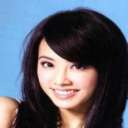

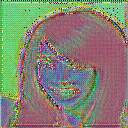

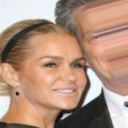

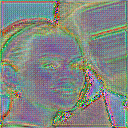

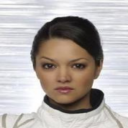

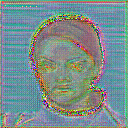

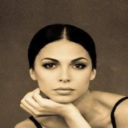

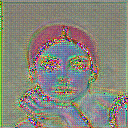

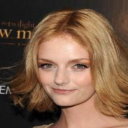

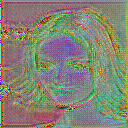

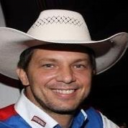

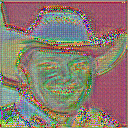

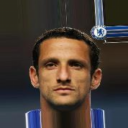

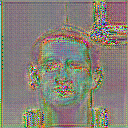

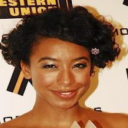

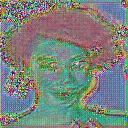

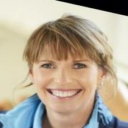

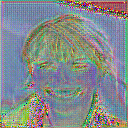

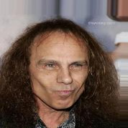

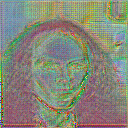

In [20]:
with torch.no_grad():
    out_images=Unet(3, 32, 3)(celeb_tensor) 
display(*[tensorToImage(image) for image in [sub[item] for item in range(len(celeb_tensor)) for sub in [celeb_tensor, out_images]]])
    

In [21]:
# loading testing dataset for UNET
from PIL import Image
test_truth=Image.open('./test_unet/testing_groundtruth.tif')
test=Image.open('./test_unet/testing.tif')
train_truth=Image.open('./test_unet/training_groundtruth.tif')
train=Image.open('./test_unet/training.tif')


In [22]:
train=transforms.functional.to_tensor(train)
train_truth=transforms.functional.to_tensor(train_truth)
test=transforms.functional.to_tensor(test)
test_truth=transforms.functional.to_tensor(test_truth)

# train=transforms.Normalize(mean=0.5, std=0.5)(train)
# train_truth=transforms.Normalize(mean=0.5, std=0.5)(train_truth)
# test=transforms.Normalize(mean=0.5, std=0.5)(test)
# test_truth=transforms.Normalize(mean=0.5, std=0.5)(test_truth)

In [23]:
# splits image into 12 parts and returns list of tensors with the contents of each image
def split_image(im, shape=(3, 4)):
    n=im.shape[1]//shape[0]
    m=im.shape[2]//shape[1]
    return torch.cat([im[:, x:x+n, y:y+m] for x in range(0, im.shape[1], n) for y in range(0, im.shape[2], m)], dim=0)

split=split_image(train, shape=(3, 4))
print(split.shape)

torch.Size([12, 256, 256])


In [24]:
train=split_image(train, shape=(3,4))
train_truth=split_image(train_truth, shape=(3,4))
test=split_image(test, shape=(3,4))
test_truth=split_image(test_truth, shape=(3,4))
train.shape

torch.Size([12, 256, 256])

In [25]:
train=torch.reshape(train, (train.shape[0], 1, train.shape[1], train.shape[2]))
train_truth=torch.reshape(train_truth, tuple(train.shape))
test=torch.reshape(test, tuple(train.shape))
test_truth=torch.reshape(test_truth, tuple(train.shape))

In [26]:
# display(*[tensorToImage(image) for image in train])

In [27]:
# testing unet on mitochondria dataset
unet_input=[train, train_truth]
validation_input=[test[:len(test)//2], test_truth[:len(test)//2]]
model=Unet(1, 64, 1)
# model=train_unet(unet_input, validation_input, model, nn.BCEWithLogitsLoss(), torch.optim.Adam(model.parameters()), 25, 4)

In [28]:
# model=train_unet(unet_input, validation_input, model, nn.BCEWithLogitsLoss(), torch.optim.Adam(model.parameters()), 25, 4)

In [29]:
# load best model
load_model=Unet(1, 64, 1)
load_model.load_state_dict(torch.load("model.pt"))
model.eval()

Unet(
  (llayer1): Conv_Block(
    (conv): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=same, bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same, bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (llayer2): Down_Block(
    (down): Sequential(
      (0): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
      (1): Conv_Block(
        (conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same, bias=False)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same, bias=False)
         

In [30]:
with torch.no_grad():
    output=load_model(test)

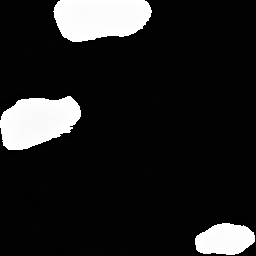

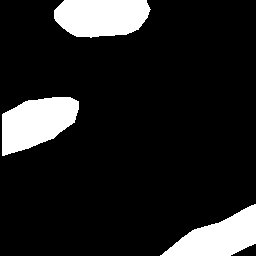

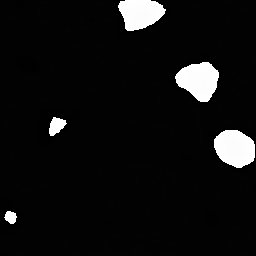

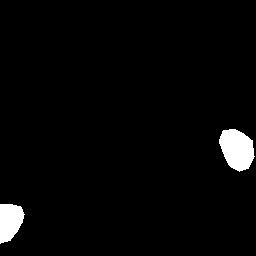

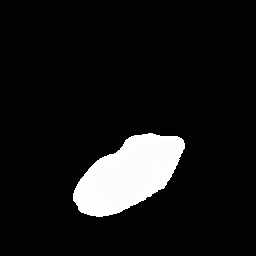

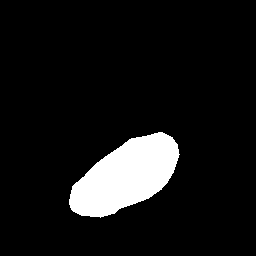

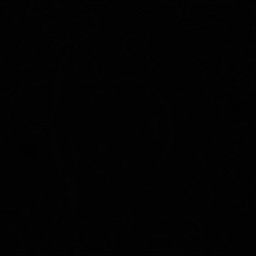

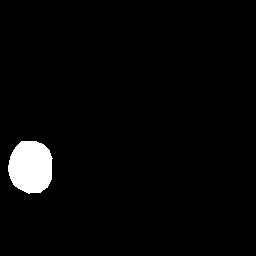

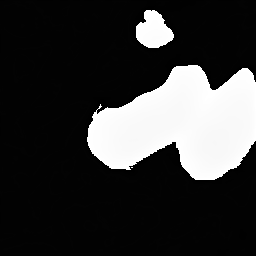

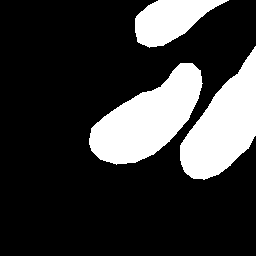

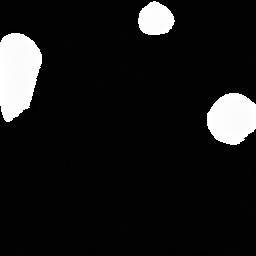

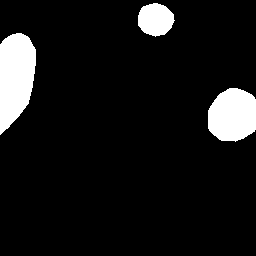

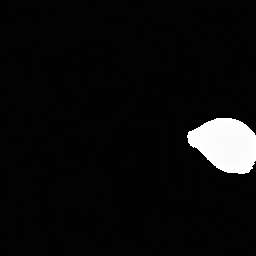

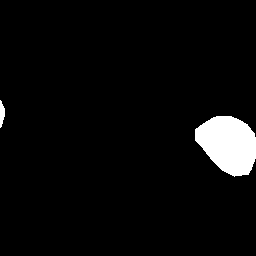

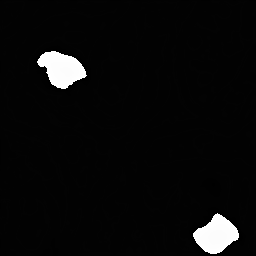

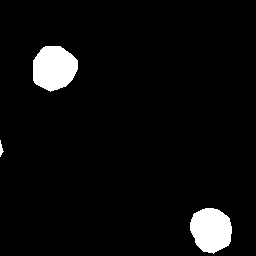

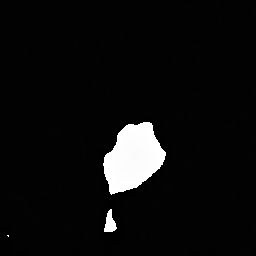

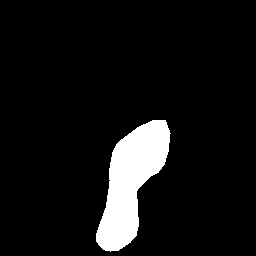

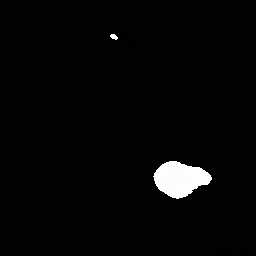

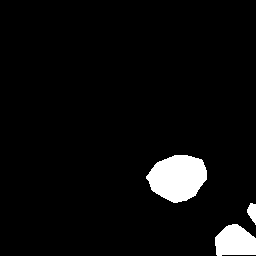

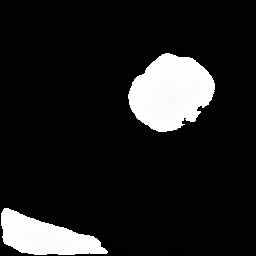

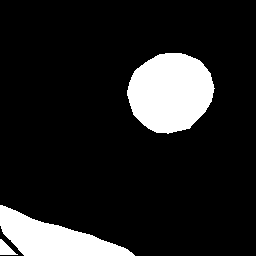

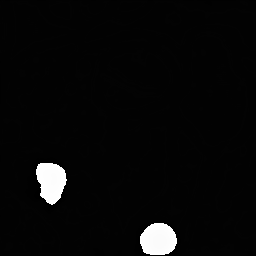

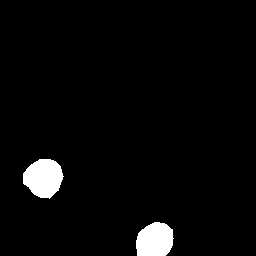

In [31]:
display(*[tensorToImage(lst[i], lambda x: torch.round(x)) for i in range(len(test)) for lst in [output, test_truth]])

In [32]:
class SinusoidalPositionalEncoding(nn.Module):
    def __init__(self, max_time_steps, dims, n=10000):
        super(SinusoidalPositionalEncoding, self).__init__()

        k=torch.arange(dims//2)
        t=torch.arange(max_time_steps).unsqueeze(dim=1)

        self.embeds=torch.zeros(max_time_steps, dims, requires_grad=False)
        self.embeds[:, 0::2]=torch.sin(t/(n**(2*k/dims)))
        self.embeds[:, 1::2]=torch.cos(t/(n**(2*k/dims)))
    
    def forward(self, t):
        return self.embeds[t, :]
    
    def to_device(self, device):
        self.embeds=self.embeds.to(device)
        self=self.to(device)

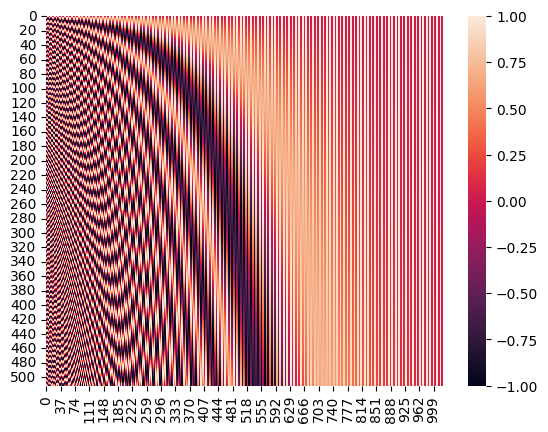

In [33]:
import seaborn as sns
sin_enc=SinusoidalPositionalEncoding(512, 1024)
ax = sns.heatmap(sin_enc(torch.arange(512)))
plt.show()

In [34]:
from einops import rearrange
class ConvTimeBlock(nn.Module):
    def __init__(self, in_channels, num_filters, t_size=None):
        super(ConvTimeBlock, self).__init__()
        self.conv1=nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=num_filters, kernel_size=(3, 3), bias=False, padding="same"),
            nn.BatchNorm2d(num_filters),
            nn.ReLU(inplace=True),
        )
        if t_size is not None:
            self.time_proj=nn.Sequential(nn.ReLU(), nn.Linear(t_size, num_filters))
        else:
            self.time_proj=None
        self.conv2=nn.Sequential(
            nn.Conv2d(in_channels=num_filters, out_channels=num_filters, kernel_size=(3, 3), bias=False, padding="same"),
            nn.BatchNorm2d(num_filters),
            nn.ReLU(inplace=True)
        )

    def forward(self, input, t_emb=None):
        input=self.conv1(input)
        if t_emb is not None:
            t_emb=self.time_proj(t_emb)
            input=rearrange(t_emb, "b c -> b c 1 1")+input
        return self.conv2(input)

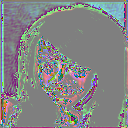

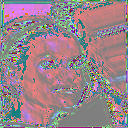

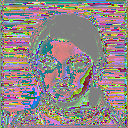

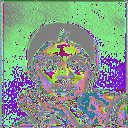

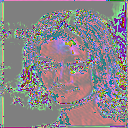

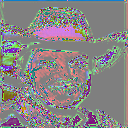

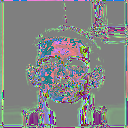

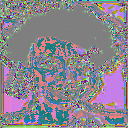

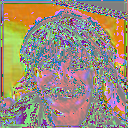

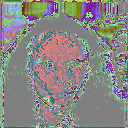

In [35]:
with torch.no_grad():
    testConvTimeBlock=ConvTimeBlock(3, 64, 1024)(celeb_tensor, sin_enc(tensor([25])))
    testConvTimeBlock=ConvTimeBlock(64, 3, 1024)(testConvTimeBlock, sin_enc(tensor([9])))
display(*[tensorToImage(image) for image in testConvTimeBlock])

In [36]:
def random_time_steps(num_time_steps, min=0, max=256):
    return torch.round((max-min)*torch.rand(num_time_steps)+min).int()

In [40]:
from torch.distributions.normal import Normal
import torch.profiler as profiler

class DownTimeBlock(nn.Module):
    def __init__(self, in_channels, num_filters, t_size=None):
        super(DownTimeBlock, self).__init__()
        self.pool=nn.MaxPool2d(kernel_size=(2,2))
        self.conv=ConvTimeBlock(in_channels, num_filters, t_size)

    def forward(self, input, t_emb):
        input=self.pool(input)
        return self.conv(input, t_emb)
    
class UpTimeBlock(nn.Module):
    def __init__(self, in_channels, num_filters, t_size=None):
        super(UpTimeBlock, self).__init__()
        self.upsample=nn.ConvTranspose2d(in_channels=in_channels, out_channels=num_filters, kernel_size=(2,2), stride=2, padding=0)
        self.conv=ConvTimeBlock(in_channels, num_filters, t_size)

    def forward(self, input, skip_connection, t_emb=None):
        diffH=skip_connection.shape[2]-input.shape[2]*2
        diffW=skip_connection.shape[3]-input.shape[3]*2
        upsampled_input=self.upsample(input)
        upsampled_input=nn.functional.pad(upsampled_input, (diffW//2, diffW-diffW//2, diffH//2, diffH-diffH//2))
        cat_input=torch.cat([skip_connection, upsampled_input], dim=1)
        return self.conv(cat_input, t_emb)
    
class DiffusionModel(nn.Module):
    def __init__(self, in_channels, out_channels, num_filters, num_timesteps=None, starting_var=0.0002, ending_var=0.02, device="cpu"):
        super(DiffusionModel, self).__init__()

        self.device=device

        # variance scheduler and time embedding
        self.sin_enc=SinusoidalPositionalEncoding(num_timesteps, num_timesteps*2)
        self.variance_schedule=torch.linspace(starting_var, ending_var, num_timesteps)
        self.alpha=1-self.variance_schedule
        self.alpha_bar=torch.cumprod(self.alpha, 0)

        # unet layers
        self.llayer1=ConvTimeBlock(in_channels, num_filters, num_timesteps*2)
        self.llayer2=DownTimeBlock(num_filters, num_filters*2, num_timesteps*2)
        self.llayer3=DownTimeBlock(num_filters*2, num_filters*4, num_timesteps*2)
        self.bottom=DownTimeBlock(num_filters*4, num_filters*8, num_timesteps*2)
        self.rlayer1=UpTimeBlock(num_filters*8, num_filters*4, num_timesteps*2)
        self.rlayer2=UpTimeBlock(num_filters*4, num_filters*2, num_timesteps*2)
        self.rlayer3=UpTimeBlock(num_filters*2, num_filters, num_timesteps*2)
        self.out_conv=nn.Conv2d(in_channels=num_filters, out_channels=out_channels, kernel_size=1)

    def forward(self, input, timesteps):
        # get time embedding
        t_emb=self.sin_enc(timesteps)

        # run input through unet
        llayer1=self.llayer1(input, t_emb)
        llayer2=self.llayer2(llayer1, t_emb)
        llayer3=self.llayer3(llayer2, t_emb)
        rlayer=self.bottom(llayer3, t_emb)
        rlayer=self.rlayer1(rlayer, llayer3, t_emb)
        rlayer=self.rlayer2(rlayer, llayer2, t_emb)
        rlayer=self.rlayer3(rlayer, llayer1, t_emb)
        return self.out_conv(rlayer)
    
    def batch(self, x, timesteps):
        x=self.bulk_timesteps_to_noise(x, timesteps)
        batch_sz=x.shape[0]
        x=x.view(-1, x.shape[2], x.shape[3], x.shape[4])
        y=self.calc_next_timestep(x, timesteps.repeat(batch_sz, 1).view(-1))
        return self.forward(x, timesteps.repeat(batch_sz, 1).view(-1)), y

    def train_one_epoch_diffusion(self, dataloader, loss_fn, optimizer, num_batches, num_timesteps=10):
        running_loss=0
        data_itr=iter(dataloader)
        for i in range(num_batches):
            # print('BATCH ', i)
            # Forward pass
            timesteps=torch.arange(num_timesteps).int().to(self.device)                                                 # calc timesteps for batch
            batchInput=next(data_itr)[0].to(self.device)                                                                # fetch batch data
            output, truth=self.batch(batchInput, timesteps)                                                             # calc predictions
            loss = loss_fn(output, truth)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            torch.cuda.synchronize()  # Ensure all CUDA operations are complete

            # Update weights
            optimizer.step()
            running_loss+=loss.item()
            # print(prof.key_averages().table(sort_by='cuda_time_total'))
        return running_loss/num_batches

    def train_diffusion(self, data, loss_fn, optimizer, epochs, batch_size, batches_per_epoch, num_timesteps=10):
        # move loss/optimizer to device
        loss_fn=loss_fn.to(self.device)

        torch.backends.cudnn.benchmark=True

        dataloader=torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)

        validation_data=next(iter(dataloader))[0].to(self.device)
        best_v_loss=2**63

        # warm up
        self.train_one_epoch_diffusion(dataloader=dataloader, loss_fn=loss_fn, optimizer=optimizer, num_batches=1, num_timesteps=2)
        print('WARMUP COMPLETE')

        for epoch in range(epochs):
            # train for 1 epoch
            model.train(True)
            avg_loss=self.train_one_epoch_diffusion(dataloader, loss_fn, optimizer, batches_per_epoch, num_timesteps)
            print('EPOCH: ', epoch, 'AVG LOSS: ', avg_loss)

            # run on validation data
            with torch.no_grad():
                v_timesteps=torch.arange(num_timesteps).int().to(self.device)                                           # calc timesteps for batch
                v_output, v_y=self.batch(validation_data, v_timesteps)                                                  # calc predictions
                v_loss=loss_fn(v_output, v_y)
            
            # save model if it performs better on validation set than previous best
            if v_loss.item()<best_v_loss:
                best_v_loss=v_loss.item()
                torch.save(model.state_dict(), "diffusion.pt")
                print("NEW BEST FOUND", best_v_loss)
            print(epoch, avg_loss)

    def to_device(self, device):                                                                                    # moves model to device
        self.device=device
        self.alpha=self.alpha.to(device)
        self.alpha_bar=self.alpha_bar.to(device)
        self.variance_schedule=self.variance_schedule.to(device)
        self.sin_enc.to_device(device)
        self=self.to(device)

    # helper functions for prepping data during training
    def forward_approx(self, img, timestep):                                                                        # approximates gaussian noise of image after t timesteps
        mean=torch.sqrt(self.alpha_bar[timestep])*img
        std=1-self.alpha_bar[timestep]
        return Normal(mean, std).rsample()
        # return normal(mean=mean, std=std, device=self.device)

    def bulk_timesteps_to_noise(self, imgs, timesteps):                                                             # Takes in tensor of images and returns noisified images at each timestep in tensor form with shape [# images, # time_steps, img size]
        batch_size, num_timesteps, *img_shape = imgs.size(0), timesteps.size(0), imgs.size(1), imgs.size(2), imgs.size(3)
        
        # Initialize an empty tensor to store the noisified images
        noisified_imgs = torch.empty((batch_size, num_timesteps, *img_shape), device=self.device)
        
        for i in range(num_timesteps):
            # Get the current timestep for the entire batch
            current_timestep = timesteps[i]
            # Approximate the noise for the entire batch at the current timestep
            noisified_imgs[:, i] = self.forward_approx(imgs, current_timestep)
        return noisified_imgs
                                             
    def add_noise(self, image, var):                                                                                # takes in image and variance and adds gaussian noise depending on that variance
        # Compute the mean and standard deviation for the Gaussian noise
        mean = torch.sqrt(1 - var) * image
        std = torch.sqrt(var)
        noise = Normal(mean, std).rsample()
        return noise
    
    def calc_next_timestep(self, imgs, timesteps):                                                                  # takes in images/timesteps and finds noisified images after 1 more timestep
        variances=self.variance_schedule[timesteps].unsqueeze(1).unsqueeze(2).unsqueeze(3)
        return self.add_noise(imgs, variances)

In [55]:
model=DiffusionModel(
    in_channels=3,
    out_channels=3,
    num_filters=64,
    num_timesteps=64,
    starting_var=0.0002,
    ending_var=0.04
)

In [57]:
import cProfile
model.to_device("cuda")
# cProfile.run("model.train_diffusion(data=celebs, loss_fn=nn.MSELoss(), optimizer=torch.optim.Adam(model.parameters()), epochs=5, batch_size=1, batches_per_epoch=1, num_timesteps=64)", sort="tottime")
model.train_diffusion(data=celebs, loss_fn=nn.MSELoss(), optimizer=torch.optim.Adam(model.parameters()), epochs=100, batch_size=1, batches_per_epoch=20, num_timesteps=64)

WARMUP COMPLETE
EPOCH:  0 AVG LOSS:  0.20429675988852977
NEW BEST FOUND 0.08713015168905258
0 0.20429675988852977
EPOCH:  1 AVG LOSS:  0.10688510481268168
NEW BEST FOUND 0.06175042316317558
1 0.10688510481268168
EPOCH:  2 AVG LOSS:  0.10363980736583471
2 0.10363980736583471
EPOCH:  3 AVG LOSS:  0.10302696730941534
NEW BEST FOUND 0.05845769867300987
3 0.10302696730941534
EPOCH:  4 AVG LOSS:  0.09515207000076771
NEW BEST FOUND 0.04638838768005371
4 0.09515207000076771
EPOCH:  5 AVG LOSS:  0.07448831964284182
5 0.07448831964284182
EPOCH:  6 AVG LOSS:  0.06538328640162945
NEW BEST FOUND 0.042308904230594635
6 0.06538328640162945
EPOCH:  7 AVG LOSS:  0.06293055471032857
7 0.06293055471032857
EPOCH:  8 AVG LOSS:  0.06545155569911003
8 0.06545155569911003
EPOCH:  9 AVG LOSS:  0.06511666085571051
9 0.06511666085571051
EPOCH:  10 AVG LOSS:  0.07236902583390474
10 0.07236902583390474
EPOCH:  11 AVG LOSS:  0.06521613765507936
NEW BEST FOUND 0.035762425512075424
11 0.06521613765507936
EPOCH:  12 A

torch.Size([1, 64, 3, 128, 128])


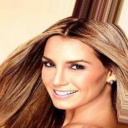

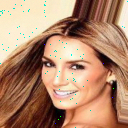

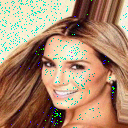

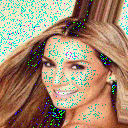

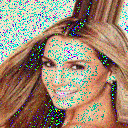

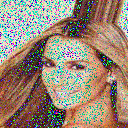

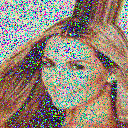

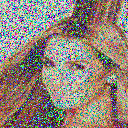

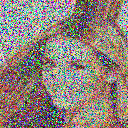

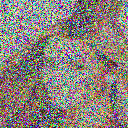

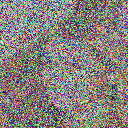

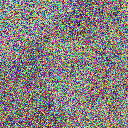

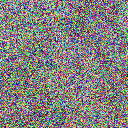

In [54]:
imgs=model.bulk_timesteps_to_noise(celebs[0][0][None, :, :, :], torch.arange(64))
print(imgs.shape)
display(*[tensorToImage(im) for i, im in enumerate(imgs[0]) if i%5==0])

torch.Size([1, 3, 128, 128])